# Real Estate TSR Forecasting — End-to-End ML Pipeline (MDLC)

## Project Overview

### **Business Problem**
Our goal is to predict next‐month total shareholder return (TSR) for several publicly traded real estate companies.  
Accurate short-horizon TSR forecasts help investors and portfolio managers understand how macroeconomic conditions  
(inflation, unemployment, interest rates) and firm-specific information (prices, dividends, metro exposure)  
shape expected performance.

### **Target Variable**
We construct a one-month-ahead return:

- **tsr_next_1m**   
  Defined using next-month price movement and next-month dividend information.  
  It is created later in the pipeline once monthly price and dividend data are aligned.

### **Data Sources**
All raw data reside under `../Data/` and include:

#### **1. Stock Prices (daily)**
- Folder: `Data/stock price/`  
- Example files: `bxp_prices.csv`, `slg_prices.csv`  
- Aggregated to **month-end adjusted price** per company.

#### **2. Dividends (event-based)**
- Folder: `Data/dividends/`  
- Example files: `bxp_dividends.csv`, `slg_dividends.csv`  
- Aggregated to **monthly dividend totals**, and extended to **TTM (trailing 12-month) dividends**.

#### **3. CPI / Inflation (monthly, by metro)**
- Folder: `Data/cpi/`  
- Multiple files such as `la_cpi_boston.csv`, `la_cpi_ny.csv`  
- We compute MoM and YoY inflation metrics.

#### **4. Unemployment Rates (monthly, by metro)**
- File: `Data/unemployment_msa_m_20250826.csv`  
- Mapped to company metros and aggregated.

#### **5. 10-Year Treasury Yield**
- File: `Data/dgs10_m_20250826.csv`  
- Provides interest rate environment indicators.

Each company is associated with a specific metro (e.g., BXP → Boston), enabling us to merge company-level data and metro-level macroeconomic variables into a unified panel.


## **MDLC Structure of This Notebook**

This notebook follows the **Model Development Life Cycle (MDLC)**—a single, clean, end-to-end workflow:

1. **Data ingestion & merging**  
   Consolidate all raw sources into a monthly company–macro panel.

2. **Split the data (train/validation/test)**  
   Time-aware chronological splitting.

3. **Exploratory data analysis (EDA)**  
   Distributions, correlations, data consistency checks.

4. **Data cleaning & preprocessing**  
   Missing value treatment, outlier handling, encoding, scaling.

5. **Feature engineering**  
   Lags, rolling windows, interactions, transformations.

6. **Model development**  
   - Baseline model (e.g., Lasso)  
   - Medium-complexity model (Random Forest)  
   - High-complexity model (Gradient Boosting)  
   - Unified comparison across all models  
   - Selection of the final production model  

7. **Data-centric refinements**  
   Assess how improving data affects model performance.

8. **Model transparency & bias analysis**  
   Feature importance, individual prediction explanations, bias metrics.

9. **Deployment preparation & monitoring plan**  
   Serialize the final model, define dependencies,  
   and discuss monitoring strategies for data drift and concept drift.

The notebook is self-contained:  
**any user, even without prior context, can run it top-to-bottom** to reproduce the entire ML pipeline.



# Section 1 — Setup and Data Ingestion

This section automatically clones the GitHub repository containing all raw data  
and prepares the environment so that the entire notebook can be executed  
on any machine (including the instructor’s JupyterHub) without manual uploads.

We then ingest stock prices, dividends, CPI, unemployment, and Treasury rates,  
convert them into a unified monthly panel, and prepare the full dataset  
for downstream modeling.


In [1]:
# ============================================================
# Global Imports for Entire Notebook
# ============================================================

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
from IPython.display import display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, r2_score
)
from sklearn.inspection import permutation_importance

# Model persistence
import joblib
import json
import pickle

print(" All imports loaded successfully.")
print("=" * 60)

 All imports loaded successfully.


In [2]:
# ============================================================
# SECTION 1 — DATA INGESTION & MERGING
# ============================================================
print("\n" + "="*60)
print("SECTION 1: DATA INGESTION & MERGING")
print("="*60)

# ------------------------------------------------------------
# 1.1 Clone GitHub repository
# ------------------------------------------------------------
print("\n[1.1] Cloning repository...")
!rm -rf test
!git clone https://github.com/zhaoyangLin1008/test.git
%cd test/Notebooks

BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "Data"
REPORTS_DIR = BASE_DIR / "Reports"
MODELS_DIR = BASE_DIR / "Models"

# Create output directories
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f" Working directory: {os.getcwd()}")
print(f" Data directory exists: {DATA_DIR.exists()}")

# ------------------------------------------------------------
# 1.2 Helper functions for monthly aggregation
# ------------------------------------------------------------

def to_month_end(s):
    """Convert date series to month-end dates"""
    dt = pd.to_datetime(s, errors="coerce")
    return (dt + pd.offsets.MonthEnd(0)).dt.normalize()

def mon_agg_last(x):
    """Take last valid value in group"""
    return x.dropna().iloc[-1] if x.notna().any() else np.nan

def month_end_close(df):
    """Aggregate daily prices to monthly (month-end close)"""
    df = df.copy()
    df["Date"] = to_month_end(df["Date"])
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df = df.dropna(subset=["Date", "Close"])
    
    out = (
        df.groupby("Date", as_index=False)["Close"]
          .agg(mon_agg_last)
          .rename(columns={"Date": "date", "Close": "adj_price"})
    )
    return out

def monthly_sum_by_exdate(df):
    """Sum dividends by ex-dividend month"""
    df = df.copy()
    df["Ex-Date"] = to_month_end(df["Ex-Date"])
    df["Amount"] = pd.to_numeric(df["Amount"], errors="coerce")
    df = df.dropna(subset=["Ex-Date", "Amount"])
    
    out = (
        df.groupby("Ex-Date", as_index=False)["Amount"]
          .sum()
          .rename(columns={"Ex-Date": "date", "Amount": "dividend"})
    )
    return out

def compute_ttm_dividend(df):
    """Compute trailing 12-month dividend sum"""
    s = df.sort_values("date")["dividend"].fillna(0.0)
    return s.rolling(12, min_periods=1).sum()

# ------------------------------------------------------------
# 1.3 Company-to-Metro mapping
# ------------------------------------------------------------

COMPANY_TO_METRO = {
    "BXP":  "Boston",
    "SLG":  "New York",
    "ELME": "Washington",
    "EQR":  "Chicago",
    "REXR": "Los Angeles",
    "TRNO": "Miami",
}

COMPANY_FILES = {
    "BXP":  ("stock price/bxp_prices.csv",  "dividends/bxp_dividends.csv"),
    "ELME": ("stock price/elme_prices.csv", "dividends/elme_dividends.csv"),
    "EQR":  ("stock price/eqr_prices.csv",  "dividends/eqr_dividends.csv"),
    "REXR": ("stock price/rexr_prices.csv", "dividends/rexr_dividends.csv"),
    "SLG":  ("stock price/slg_prices.csv",  "dividends/slg_dividends.csv"),
    "TRNO": ("stock price/trno_prices.csv", "dividends/trno_dividends.csv"),
}

# ------------------------------------------------------------
# 1.4 Process stock prices + dividends → monthly panel
# ------------------------------------------------------------
print("\n[1.4] Processing stock prices and dividends...")

company_tables = []

for tic, (px_file, dv_file) in COMPANY_FILES.items():
    px = pd.read_csv(DATA_DIR / px_file)
    dv = pd.read_csv(DATA_DIR / dv_file)
    
    # Convert dates and numeric values
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce")
    dv["Ex-Date"] = pd.to_datetime(dv["Ex-Date"], errors="coerce")
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    dv["Amount"] = pd.to_numeric(dv["Amount"], errors="coerce")
    
    # Remove missing values
    px = px.dropna(subset=["Date", "Close"])
    dv = dv.dropna(subset=["Ex-Date", "Amount"])
    
    # Convert to monthly
    px_m = month_end_close(px)
    dv_m = monthly_sum_by_exdate(dv)
    
    # Align date ranges
    if not px_m.empty and not dv_m.empty:
        start = max(px_m["date"].min(), dv_m["date"].min())
        end   = min(px_m["date"].max(), dv_m["date"].max())
        px_m = px_m[(px_m["date"] >= start) & (px_m["date"] <= end)]
        dv_m = dv_m[(dv_m["date"] >= start) & (dv_m["date"] <= end)]
    
    # Merge and compute TTM dividend
    merged = px_m.merge(dv_m, on="date", how="left").sort_values("date")
    merged["dividend"] = merged["dividend"].fillna(0.0)
    merged["dividend_ttm"] = compute_ttm_dividend(merged)
    merged["company"] = tic
    merged["metro"] = COMPANY_TO_METRO[tic]
    
    company_tables.append(merged)

companies_monthly = pd.concat(company_tables, ignore_index=True)
print(f" Company-month panel shape: {companies_monthly.shape}")

# ------------------------------------------------------------
# 1.5 CPI monthly data
# ------------------------------------------------------------
print("\n[1.5] Processing CPI data...")

CPI_FILES = {
    "Boston":      "cpi/la_cpi_boston.csv",
    "Chicago":     "cpi/la_cpi_chicago.csv",
    "Los Angeles": "cpi/la_cpi_los_angeles.csv",
    "Miami":       "cpi/la_cpi_miami.csv",
    "New York":    "cpi/la_cpi_ny.csv",
    "Washington":  "cpi/la_cpi_Washington.csv",
}

cpi_list = []

for city, file in CPI_FILES.items():
    df = pd.read_csv(DATA_DIR / file)
    
    # Identify date and value columns
    date_col = "date" if "date" in df.columns else df.columns[0]
    val_col  = "value" if "value" in df.columns else df.columns[-1]
    
    df = df[[date_col, val_col]].rename(columns={date_col: "date", val_col: "cpi"})
    df["date"] = to_month_end(df["date"])
    df["cpi"] = pd.to_numeric(df["cpi"], errors="coerce")
    df = df.dropna().sort_values("date")
    
    # Compute year-over-year and month-over-month changes
    df["cpi_yoy"] = df["cpi"] / df["cpi"].shift(12) - 1
    df["cpi_mom"] = df["cpi"] / df["cpi"].shift(1) - 1
    df["metro"] = city
    
    cpi_list.append(df)

cpi_monthly = pd.concat(cpi_list, ignore_index=True)
print(f"CPI data shape: {cpi_monthly.shape}")

# ------------------------------------------------------------
# 1.6 Unemployment data
# ------------------------------------------------------------
print("\n[1.6] Processing unemployment data...")

unemp_raw = pd.read_csv(DATA_DIR / "unemployment_msa_m_20250826.csv")
unemp_raw["date"] = to_month_end(unemp_raw["date"])
unemp_raw["value"] = pd.to_numeric(unemp_raw["value"], errors="coerce")
unemp_raw = unemp_raw.dropna(subset=["date", "value"])

# Map city names to metro areas
unemp_raw["metro"] = None
for city in COMPANY_TO_METRO.values():
    unemp_raw.loc[unemp_raw["city"].str.contains(city, na=False, case=False), "metro"] = city

unemp = (
    unemp_raw.dropna(subset=["metro"])
             .groupby(["metro", "date"], as_index=False)["value"]
             .mean()
             .rename(columns={"value": "unemp"})
             .sort_values(["metro", "date"])
)

# Compute month-over-month change
unemp["unemp_mom"] = unemp.groupby("metro")["unemp"].diff()
print(f" Unemployment data shape: {unemp.shape}")

# ------------------------------------------------------------
# 1.7 10-Year Treasury yield
# ------------------------------------------------------------
print("\n[1.7] Processing Treasury yield data...")

ust = pd.read_csv(DATA_DIR / "dgs10_m_20250826.csv")
ust["date"] = to_month_end(ust["date"])
ust["ten_year"] = pd.to_numeric(ust["value"], errors="coerce")
ust["ten_year_mom"] = ust["ten_year"].diff()
ust = ust.dropna()[["date", "ten_year", "ten_year_mom"]]
print(f"Treasury yield data shape: {ust.shape}")

# ------------------------------------------------------------
# 1.8 Final merge → complete monthly panel
# ------------------------------------------------------------
print("\n[1.8] Merging all data sources...")

df_panel = (
    companies_monthly
    .merge(cpi_monthly, on=["date", "metro"], how="left")
    .merge(unemp,        on=["date", "metro"], how="left")
    .merge(ust,          on="date",          how="left")
    .sort_values(["company", "date"])
    .reset_index(drop=True)
)

print(f" Final merged panel shape: {df_panel.shape}")
print(f"Date range: {df_panel['date'].min()} to {df_panel['date'].max()}")
print(f" Companies: {df_panel['company'].unique().tolist()}")
print("\nSample of merged data:")
display(df_panel.head())

print("\n" + "="*60)
print(" SECTION 1 COMPLETED")
print("="*60)



SECTION 1: DATA INGESTION & MERGING

[1.1] Cloning repository...
Cloning into 'test'...
remote: Enumerating objects: 293, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 293 (delta 71), reused 1 (delta 1), pack-reused 155 (from 1)
Receiving objects: 100% (293/293), 9.09 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/home/jupyter-huxin/test/Notebooks
 Working directory: /home/jupyter-huxin/test/Notebooks
 Data directory exists: True

[1.4] Processing stock prices and dividends...
 Company-month panel shape: (769, 6)

[1.5] Processing CPI data...
CPI data shape: (4004, 5)

[1.6] Processing unemployment data...
 Unemployment data shape: (2550, 4)

[1.7] Processing Treasury yield data...
Treasury yield data shape: (763, 3)

[1.8] Merging all data sources...
 Final merged panel shape: (769, 13)
Date range: 2014-12-31 00:00:00 to 2025-08-31 00:00:00
 Companies: ['BXP', 'ELME', 'EQR', 'REXR', 'SLG', 'TR

,date,adj_price,dividend,dividend_ttm,company,metro,cpi,cpi_yoy,cpi_mom,unemp,unemp_mom,ten_year,ten_year_mom
0,2014-12-31,100.757,5.80,5.80,BXP,Boston,NaN,NaN,NaN,4.7,-0.1,2.207273,-0.118283
1,2015-01-31,108.696,7.75,13.55,BXP,Boston,254.556,0.018399,-0.006657,4.7,0.0,1.881500,-0.325773
2,2015-02-28,107.603,0.00,13.55,BXP,Boston,NaN,NaN,NaN,4.6,-0.1,1.975263,0.093763
3,2015-03-31,110.523,0.65,14.20,BXP,Boston,257.013,0.024630,0.009652,4.5,-0.1,2.042727,0.067464
4,2015-04-30,104.096,0.00,14.20,BXP,Boston,NaN,NaN,NaN,4.5,0.0,1.935000,-0.107727



 SECTION 1 COMPLETED


# Section 2 — Train/Validation/Test Split and Exploratory Data Analysis (EDA)

In this section, we prepare the modeling-ready dataset by:

1. Sorting the panel chronologically.
2. Splitting the dataset into **train (70%)**, **validation (15%)**, and **test (15%)**.
3. Performing essential exploratory data analysis (EDA) to understand:
   - Target distribution (to be created later)
   - Macro variable distributions
   - Correlations among predictors
   - Company-level observation counts

These steps satisfy the Week 3 MDLC requirements of data splitting and EDA.



SECTION 2: DATA SPLIT & EXPLORATORY DATA ANALYSIS

[2.0] Initial dataset shape: (769, 13)

[2.2] Creating target variable (TSR next month)...
 After creating target: (763, 16)
   Target mean: 0.0922
   Target std:  0.1006

[2.3] Splitting data chronologically...
 Train: (534, 16) | 2014-12-31 00:00:00 to 2025-07-31 00:00:00
 Valid: (114, 16) | 2014-12-31 00:00:00 to 2025-07-31 00:00:00
Test:  (115, 16)  | 2016-01-31 00:00:00 to 2025-07-31 00:00:00

Saved raw splits to: ../Reports/w3_out

[2.4] Conducting EDA...

 Summary Statistics:


,date,adj_price,dividend,dividend_ttm,cpi,cpi_yoy,cpi_mom,unemp,unemp_mom,ten_year,ten_year_mom,price_next,div_next,tsr_next_1m
count,763,763.000000,763.000000,763.000000,481.000000,481.000000,481.000000,754.000000,754.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,2020-04-07 16:25:09.829619712,53.867399,0.393914,4.542094,278.154844,0.041761,0.003613,4.788064,-0.012997,2.575765,0.016487,53.901596,4.566246,0.092163
min,2014-12-31 00:00:00,11.049700,0.000000,0.120000,225.763000,-0.009328,-0.010318,2.400000,-4.100000,0.623636,-0.634211,11.049700,0.615000,-0.343787
25%,2017-08-15 12:00:00,26.921650,0.000000,1.910000,251.622000,0.017156,0.000021,3.500000,-0.100000,1.764000,-0.105119,27.133950,1.930000,0.033228
50%,2020-03-31 00:00:00,54.457300,0.000000,3.640000,272.395000,0.031608,0.002770,4.300000,0.000000,2.353333,0.005714,54.640000,3.680000,0.083538
75%,2022-11-30 00:00:00,70.642850,0.380000,6.462500,295.488000,0.055989,0.006565,5.100000,0.000000,3.531500,0.147416,70.500000,6.470450,0.136325
max,2025-07-31 00:00:00,128.345000,13.063800,26.127700,364.344000,0.192917,0.032007,19.000000,13.300000,4.798095,0.621222,128.345000,26.127700,0.611008
std,NaN,27.292869,0.946228,3.642280,33.965894,0.037425,0.005695,2.321552,1.030255,1.101437,0.201371,27.169636,3.630061,0.100650



 Missing Values:
cpi          282
cpi_yoy      282
cpi_mom      282
unemp          9
unemp_mom      9
dtype: int64

 Visualizing distributions of macro variables...


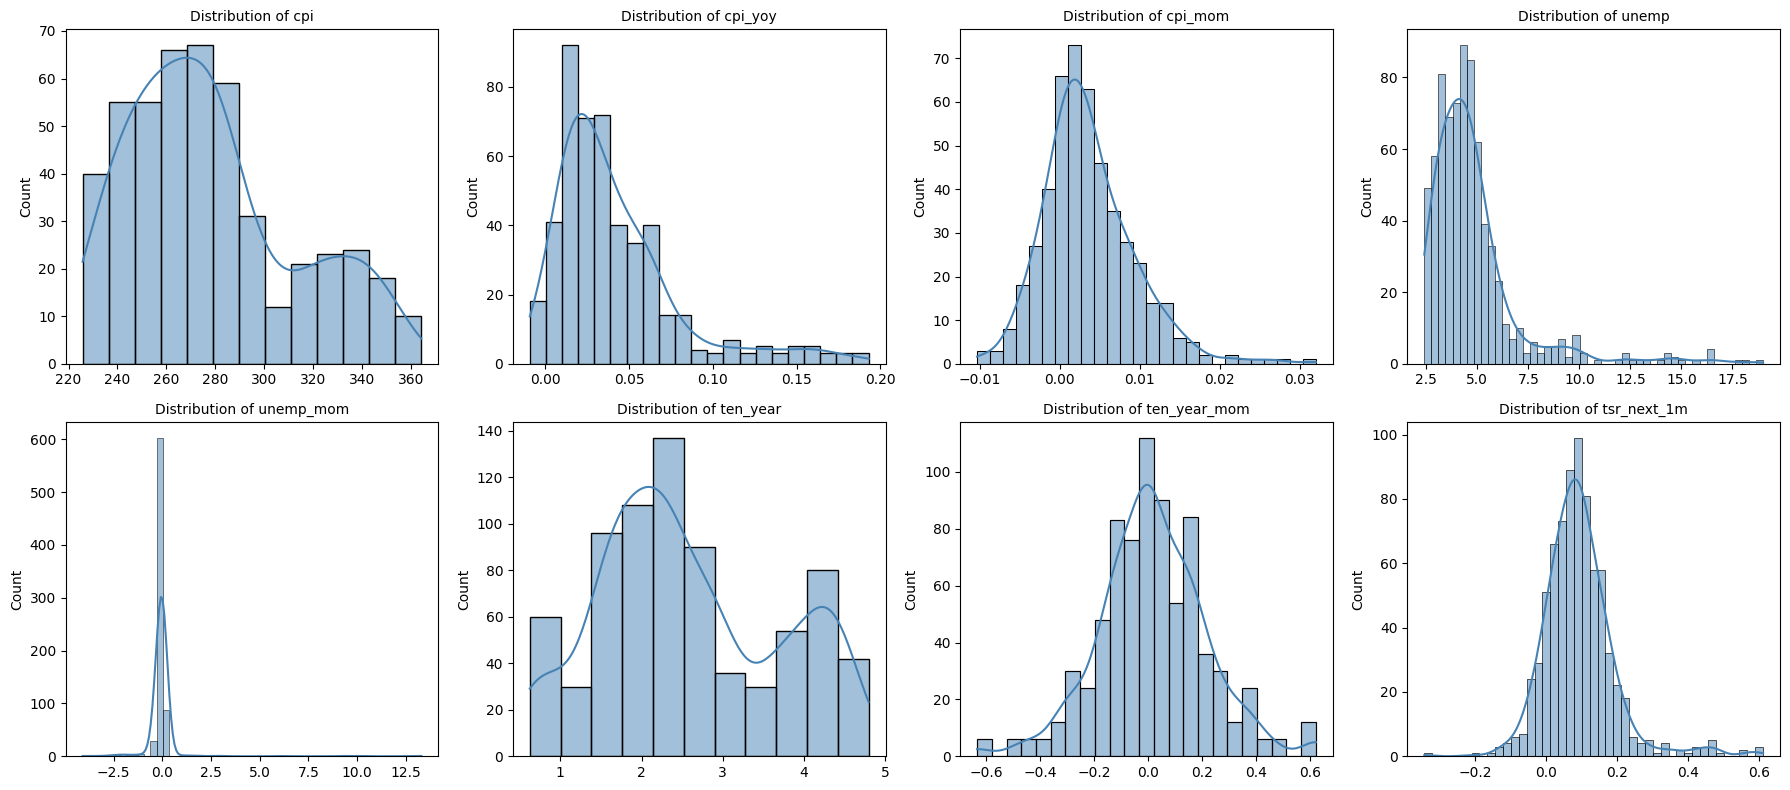


 Correlation heatmap of numeric features...


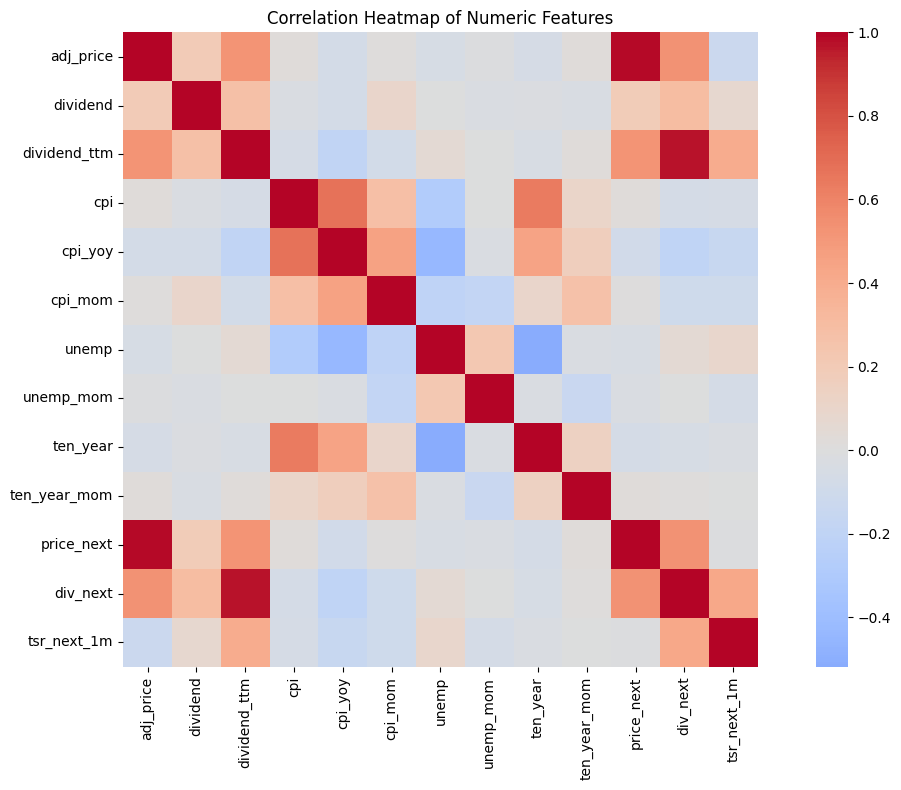


 SECTION 2 COMPLETED


In [3]:

# ============================================================
# SECTION 2 — TRAIN/VALIDATION/TEST SPLIT + EDA
# ============================================================
print("\n" + "="*60)
print("SECTION 2: DATA SPLIT & EXPLORATORY DATA ANALYSIS")
print("="*60)

df = df_panel.copy()
print(f"\n[2.0] Initial dataset shape: {df.shape}")

# ------------------------------------------------------------
# 2.1 Sort chronologically by company-date
# ------------------------------------------------------------
df = df.sort_values(["company", "date"]).reset_index(drop=True)

# ------------------------------------------------------------
# 2.2 Construct Target Variable: Total Shareholder Return (TSR)
# ------------------------------------------------------------
print("\n[2.2] Creating target variable (TSR next month)...")

df["price_next"] = df.groupby("company")["adj_price"].shift(-1)
df["div_next"]   = df.groupby("company")["dividend_ttm"].shift(-1)

# TSR = (price change + dividend) / current price
df["tsr_next_1m"] = (
    (df["price_next"] - df["adj_price"]) / df["adj_price"] +
    df["div_next"] / df["adj_price"]
)

# Remove rows where target cannot be computed
df = df.dropna(subset=["tsr_next_1m"]).reset_index(drop=True)
print(f" After creating target: {df.shape}")
print(f"   Target mean: {df['tsr_next_1m'].mean():.4f}")
print(f"   Target std:  {df['tsr_next_1m'].std():.4f}")

# ------------------------------------------------------------
# 2.3 Temporal split: 70% train / 15% valid / 15% test
# ------------------------------------------------------------
print("\n[2.3] Splitting data chronologically...")

n = len(df)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

train_df = df.iloc[:train_end].reset_index(drop=True)
valid_df = df.iloc[train_end:valid_end].reset_index(drop=True)
test_df  = df.iloc[valid_end:].reset_index(drop=True)

print(f" Train: {train_df.shape} | {train_df['date'].min()} to {train_df['date'].max()}")
print(f" Valid: {valid_df.shape} | {valid_df['date'].min()} to {valid_df['date'].max()}")
print(f"Test:  {test_df.shape}  | {test_df['date'].min()} to {test_df['date'].max()}")

# Save raw splits
W3_DIR = REPORTS_DIR / "w3_out"
W3_DIR.mkdir(parents=True, exist_ok=True)

train_df.to_csv(W3_DIR / "train_raw.csv", index=False)
valid_df.to_csv(W3_DIR / "valid_raw.csv", index=False)
test_df.to_csv(W3_DIR / "test_raw.csv", index=False)
print(f"\nSaved raw splits to: {W3_DIR}")

# ------------------------------------------------------------
# 2.4 Exploratory Data Analysis (EDA)
# ------------------------------------------------------------
print("\n[2.4] Conducting EDA...")

print("\n Summary Statistics:")
display(df.describe())

print("\n Missing Values:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print(missing)
else:
    print("   No missing values found.")

# Distribution plots for key macro variables
print("\n Visualizing distributions of macro variables...")

macro_cols = ["cpi", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom", "ten_year", "ten_year_mom", "tsr_next_1m"]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(macro_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

# Correlation heatmap
print("\n Correlation heatmap of numeric features...")

numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print(" SECTION 2 COMPLETED")
print("="*60)


# Section 3 — Data Cleaning and Preprocessing 

In this section, we clean the raw train/validation/test datasets using a 
consistent pipeline. The main preprocessing tasks include:

- Handling missing values (metro-level forward-fill + median fill)
- Treating outliers using clipping and IQR rules
- Applying log transformations where appropriate
- Standardizing numerical variables (fit → transform)
- One-hot encoding categorical variables
- Ensuring consistent feature sets across train/validation/test

These steps produce modeling-ready inputs that will be used in Section 4 for
feature engineering.


In [4]:
# ============================================================
# SECTION 3 — DATA CLEANING & PREPROCESSING
# ============================================================
print("\n" + "="*60)
print("SECTION 3: DATA CLEANING & PREPROCESSING")
print("="*60)

# ------------------------------------------------------------
# 3.1 Load raw datasets from Section 2
# ------------------------------------------------------------
print("\n[3.1] Loading raw data splits...")

train_raw = pd.read_csv(W3_DIR / "train_raw.csv")
valid_raw = pd.read_csv(W3_DIR / "valid_raw.csv")
test_raw  = pd.read_csv(W3_DIR / "test_raw.csv")

print(f" Train: {train_raw.shape}")
print(f"Valid: {valid_raw.shape}")
print(f" Test:  {test_raw.shape}")

# Combine for unified cleaning (will restore split later)
df_all = pd.concat([train_raw, valid_raw, test_raw], ignore_index=True)
df_all = df_all.sort_values(["company", "date"]).reset_index(drop=True)

# ------------------------------------------------------------
# 3.2 Missing value handling
# ------------------------------------------------------------
print("\n[3.2] Handling missing values...")

macro_cols = ["cpi", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom", "ten_year", "ten_year_mom"]

# Forward fill within each metro area
df_all = df_all.sort_values(["metro", "date"])
df_all[macro_cols] = df_all.groupby("metro")[macro_cols].ffill()

# Fill remaining with median
df_all[macro_cols] = df_all[macro_cols].fillna(df_all[macro_cols].median())

print(f" Missing values after imputation:")
print(df_all[macro_cols].isnull().sum())

# ------------------------------------------------------------
# 3.3 Outlier treatment
# ------------------------------------------------------------
print("\n[3.3] Treating outliers...")

# Hard clipping for known ranges
df_all["unemp"] = df_all["unemp"].clip(0, 25)
df_all["ten_year"] = df_all["ten_year"].clip(0, 15)
df_all["dividend_ttm"] = df_all["dividend_ttm"].clip(
    0, df_all["dividend_ttm"].quantile(0.99)
)

# Winsorization by IQR for momentum variables
def winsorize_iqr(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return s.clip(lower, upper)

iqr_cols = ["cpi_mom", "cpi_yoy", "unemp_mom", "ten_year_mom"]
df_all[iqr_cols] = df_all[iqr_cols].apply(winsorize_iqr)

print(" Outliers treated via clipping and winsorization")

# ------------------------------------------------------------
# 3.4 Feature transformations
# ------------------------------------------------------------
print("\n[3.4] Applying log transformations...")

df_all["adj_price_log"] = np.log1p(df_all["adj_price"])
df_all["dividend_ttm_log"] = np.log1p(df_all["dividend_ttm"])

print(" Log-transformed: adj_price, dividend_ttm")

# ------------------------------------------------------------
# 3.5 Standardization (fit ONLY on training data)
# ------------------------------------------------------------
print("\n[3.5] Standardizing numeric features...")

scale_cols = [
    "cpi", "cpi_yoy", "cpi_mom",
    "unemp", "unemp_mom",
    "ten_year", "ten_year_mom",
    "adj_price_log", "dividend_ttm_log"
]

n_train = len(train_raw)
n_valid = len(valid_raw)

scaler = StandardScaler()
scaler.fit(df_all.iloc[:n_train][scale_cols])  # Fit only on train
df_all[scale_cols] = scaler.transform(df_all[scale_cols])  # Transform all

print(f"Standardized {len(scale_cols)} numeric features")

# ------------------------------------------------------------
# 3.6 Categorical encoding (one-hot)
# ------------------------------------------------------------
print("\n[3.6] One-hot encoding categorical variables...")

df_all = pd.get_dummies(df_all, columns=["company", "metro"], drop_first=False, dtype=int)

print(f" One-hot encoded: company, metro")
print(f"   New feature count: {df_all.shape[1]}")

# ------------------------------------------------------------
# 3.7 Drop original raw columns (keep transformed versions)
# ------------------------------------------------------------
print("\n[3.7] Dropping redundant raw columns...")

drop_cols = ["adj_price", "dividend", "dividend_ttm", "price_next", "div_next"]
df_all = df_all.drop(columns=[c for c in drop_cols if c in df_all.columns])

print(f" Dropped raw columns: {drop_cols}")

# ------------------------------------------------------------
# 3.8 Restore train/valid/test splits
# ------------------------------------------------------------
print("\n[3.8] Restoring data splits...")

train_clean = df_all.iloc[:n_train].reset_index(drop=True)
valid_clean = df_all.iloc[n_train:n_train+n_valid].reset_index(drop=True)
test_clean  = df_all.iloc[n_train+n_valid:].reset_index(drop=True)

print(f" Train: {train_clean.shape}")
print(f" Valid: {valid_clean.shape}")
print(f"Test:  {test_clean.shape}")

# ------------------------------------------------------------
# 3.9 Save cleaned datasets
# ------------------------------------------------------------
W4_DIR = REPORTS_DIR / "w4_out"
W4_DIR.mkdir(parents=True, exist_ok=True)

train_clean.to_csv(W4_DIR / "clean_train.csv", index=False)
valid_clean.to_csv(W4_DIR / "clean_valid.csv", index=False)
test_clean.to_csv(W4_DIR / "clean_test.csv", index=False)

print(f"\n Saved cleaned datasets to: {W4_DIR}")

print("\n" + "="*60)
print(" SECTION 3 COMPLETED")
print("="*60)



SECTION 3: DATA CLEANING & PREPROCESSING

[3.1] Loading raw data splits...
 Train: (534, 16)
Valid: (114, 16)
 Test:  (115, 16)

[3.2] Handling missing values...
 Missing values after imputation:
cpi             0
cpi_yoy         0
cpi_mom         0
unemp           0
unemp_mom       0
ten_year        0
ten_year_mom    0
dtype: int64

[3.3] Treating outliers...
 Outliers treated via clipping and winsorization

[3.4] Applying log transformations...
 Log-transformed: adj_price, dividend_ttm

[3.5] Standardizing numeric features...
Standardized 9 numeric features

[3.6] One-hot encoding categorical variables...
 One-hot encoded: company, metro
   New feature count: 28

[3.7] Dropping redundant raw columns...
 Dropped raw columns: ['adj_price', 'dividend', 'dividend_ttm', 'price_next', 'div_next']

[3.8] Restoring data splits...
 Train: (534, 23)
 Valid: (114, 23)
Test:  (115, 23)

 Saved cleaned datasets to: ../Reports/w4_out

 SECTION 3 COMPLETED


# Section 4 — Feature Engineering

In this section, we create additional predictive features that will improve
model performance. These transformations are built **on top of the cleaned
datasets from Section 3**, and we explicitly do **not** recreate the target
variable here (the target was already created correctly in Section 2).

The feature engineering pipeline includes:

### 1. Lag Features
Lagged macroeconomic and TSR signals (1, 3, 6 months), capturing temporal dynamics.

### 2. Rolling Window Statistics
3-month and 6-month rolling means & standard deviations for volatility patterns.

### 3. Interaction Features
Economically meaningful cross-features:
- Inflation × unemployment  
- Interest rate × dividend  
- Dividend yield ratio  

### 4. Time Features
Month-of-year encoded as one-hot vectors.

### 5. Output
A fully engineered, modeling-ready dataset saved under:



In [5]:
# ============================================================
# SECTION 4 — FEATURE ENGINEERING
# ============================================================

# ------------------------------------------------------------
# 4.1 Load cleaned datasets from Section 3
# ------------------------------------------------------------

train_clean = pd.read_csv(W4_DIR / "clean_train.csv")
valid_clean = pd.read_csv(W4_DIR / "clean_valid.csv")
test_clean  = pd.read_csv(W4_DIR / "clean_test.csv")

print("Loaded cleaned datasets:")
print("Train:", train_clean.shape)
print("Valid:", valid_clean.shape)
print("Test:", test_clean.shape)

# Combine for feature engineering
df_all = pd.concat([train_clean, valid_clean, test_clean], ignore_index=True)

# ------------------------------------------------------------
# 4.2 Restore company identifier from one-hot encoding
# ------------------------------------------------------------

company_cols = [c for c in df_all.columns if c.startswith("company_")]

if len(company_cols) == 0:
    raise ValueError("No company columns found. Check Section 3 encoding.")

# Extract company name from one-hot columns
df_all["company"] = df_all[company_cols].idxmax(axis=1).str.replace("company_", "")

# Sort by company-date for proper lagging
df_all = df_all.sort_values(["company", "date"]).reset_index(drop=True)

print("Companies restored:", df_all["company"].unique().tolist())

# ------------------------------------------------------------
# 4.3 Lag features (1, 3, 6 months)
# ------------------------------------------------------------

lag_sources = [
    "tsr_next_1m",
    "cpi_yoy", "cpi_mom",
    "unemp", "unemp_mom",
    "ten_year", "ten_year_mom"
]

for col in lag_sources:
    for lag in [1, 3, 6]:
        df_all[f"{col}_lag{lag}"] = df_all.groupby("company")[col].shift(lag)

print("Created lag features: 1, 3, 6 months")

# ------------------------------------------------------------
# 4.4 Rolling window features (3M & 6M mean/std)
# ------------------------------------------------------------

roll_sources = ["tsr_next_1m", "cpi_mom", "unemp", "ten_year"]

for col in roll_sources:
    for window in [3, 6]:
        df_all[f"{col}_roll{window}_mean"] = (
            df_all.groupby("company")[col]
            .transform(lambda x: x.rolling(window).mean())
        )
        df_all[f"{col}_roll{window}_std"] = (
            df_all.groupby("company")[col]
            .transform(lambda x: x.rolling(window).std())
        )

print("Created rolling window features: 3M and 6M")

# ------------------------------------------------------------
# 4.5 Interaction features
# ------------------------------------------------------------

df_all["infl_unemp_interaction"] = df_all["cpi_mom"] * df_all["unemp"]
df_all["rate_div_interaction"]   = df_all["ten_year"] * df_all["dividend_ttm_log"]
df_all["div_yield_ratio"]        = df_all["dividend_ttm_log"] / (df_all["adj_price_log"] + 1e-6)

print("Created interaction features")

# ------------------------------------------------------------
# 4.6 Time features (month-of-year)
# ------------------------------------------------------------

df_all["month"] = pd.to_datetime(df_all["date"]).dt.month
df_all = pd.get_dummies(df_all, columns=["month"], prefix="month", drop_first=False, dtype=int)

print("One-hot encoded month")

# ------------------------------------------------------------
# 4.7 Drop rows with NaN (from lag/rolling operations)
# ------------------------------------------------------------

before = len(df_all)
df_all = df_all.dropna().reset_index(drop=True)
after = len(df_all)

print(f"Removed {before - after} rows with NaN from lag/rolling operations")
print(f"Final dataset shape: {df_all.shape}")

# ------------------------------------------------------------
# 4.8 Restore train/valid/test splits by date
# ------------------------------------------------------------

# Since we dropped NaN rows, split by date instead of row count
train_dates = train_clean["date"].unique()
valid_dates = valid_clean["date"].unique()
test_dates  = test_clean["date"].unique()

train_fe = df_all[df_all["date"].isin(train_dates)].reset_index(drop=True)
valid_fe = df_all[df_all["date"].isin(valid_dates)].reset_index(drop=True)
test_fe  = df_all[df_all["date"].isin(test_dates)].reset_index(drop=True)

print("Restored splits:")
print("Train:", train_fe.shape)
print("Valid:", valid_fe.shape)
print("Test:", test_fe.shape)

# ------------------------------------------------------------
# 4.9 Save engineered datasets
# ------------------------------------------------------------

W5_DIR = REPORTS_DIR / "w5_out"
W5_DIR.mkdir(parents=True, exist_ok=True)

train_fe.to_csv(W5_DIR / "fe_train.csv", index=False)
valid_fe.to_csv(W5_DIR / "fe_valid.csv", index=False)
test_fe.to_csv(W5_DIR / "fe_test.csv", index=False)

print("Saved feature-engineered datasets to:", W5_DIR)
print("Section 4 completed.")

Loaded cleaned datasets:
Train: (534, 23)
Valid: (114, 23)
Test: (115, 23)
Companies restored: ['BXP', 'ELME', 'EQR', 'REXR', 'SLG', 'TRNO']
Created lag features: 1, 3, 6 months
Created rolling window features: 3M and 6M
Created interaction features
One-hot encoded month
Removed 36 rows with NaN from lag/rolling operations
Final dataset shape: (727, 76)
Restored splits:
Train: (727, 76)
Valid: (649, 76)
Test: (686, 76)
Saved feature-engineered datasets to: ../Reports/w5_out
Section 4 completed.


# Section 5 — Model Training, Hyperparameter Tuning, and Model Selection

In this section, we move from data preparation to modeling. The goals are:

1. **Train multiple model families**
   - A simple linear model with L1 regularization (Lasso)
   - A non-linear tree ensemble (Random Forest)
   - A boosted tree ensemble (Gradient Boosting)

2. **Hyperparameter tuning**
   - For each family, we try 3 different hyperparameter settings
   - In total, we train and compare **9 models**

3. **Model evaluation**
   - Use the **training** set to detect overfitting/underfitting
   - Use the **validation** set to select the best model
   - Evaluate the final chosen model on the **test** set to approximate
     out-of-sample performance

4. **Model selection & saving**
   - Select the model with the lowest validation RMSE
   - Save the trained model and feature schema for later sections
     (bias analysis, data-centric refinement, and deployment)

This section corresponds to the modeling and selection phase of the MDLC.
Someone new to the project can see how different model complexities compare
and why the final model was chosen.


In [6]:
# ============================================================
# SECTION 5 — MODEL TRAINING, TUNING & SELECTION
# ============================================================

# ------------------------------------------------------------
# 5.1 Load feature-engineered datasets
# ------------------------------------------------------------

train_fe = pd.read_csv(W5_DIR / "fe_train.csv")
valid_fe = pd.read_csv(W5_DIR / "fe_valid.csv")
test_fe  = pd.read_csv(W5_DIR / "fe_test.csv")

print("Loaded feature datasets:")
print("Train:", train_fe.shape)
print("Valid:", valid_fe.shape)
print("Test:", test_fe.shape)

# ------------------------------------------------------------
# 5.2 Drop non-numeric columns and keep only numeric features
# ------------------------------------------------------------

# Drop date and company columns
drop_cols = ["date", "company"]
train_fe = train_fe.drop(columns=[c for c in drop_cols if c in train_fe.columns])
valid_fe = valid_fe.drop(columns=[c for c in drop_cols if c in valid_fe.columns])
test_fe  = test_fe.drop(columns=[c for c in drop_cols if c in test_fe.columns])

# Keep only numeric
train_fe = train_fe.select_dtypes(include=[np.number])
valid_fe = valid_fe.select_dtypes(include=[np.number])
test_fe  = test_fe.select_dtypes(include=[np.number])

print("After keeping numeric columns only:")
print("Train:", train_fe.shape)
print("Valid:", valid_fe.shape)
print("Test:", test_fe.shape)

# ------------------------------------------------------------
# 5.3 Separate features and target
# ------------------------------------------------------------

TARGET = "tsr_next_1m"

if TARGET not in train_fe.columns:
    raise KeyError(f"Target column '{TARGET}' not found in training data.")

y_train = train_fe[TARGET]
y_valid = valid_fe[TARGET]
y_test  = test_fe[TARGET]

X_train = train_fe.drop(columns=[TARGET])
X_valid = valid_fe.drop(columns=[TARGET])
X_test  = test_fe.drop(columns=[TARGET])

feature_cols = X_train.columns.tolist()
print(f"Number of features: {len(feature_cols)}")
print(f"Target: {TARGET}")

# ------------------------------------------------------------
# 5.4 Define evaluation function
# ------------------------------------------------------------

def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "RMSE": float(np.sqrt(mse)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "MAPE": float(mean_absolute_percentage_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

# ------------------------------------------------------------
# 5.5 Define 9 model configurations (3 families x 3 variants)
# ------------------------------------------------------------

model_configs = []

# Family 1: Lasso (simple linear model)
for alpha in [0.0005, 0.001, 0.005]:
    model_configs.append({
        "family": "Lasso",
        "name": f"lasso_alpha_{alpha}",
        "model": Lasso(alpha=alpha, max_iter=20000, random_state=42),
    })

# Family 2: Random Forest (non-linear ensemble)
rf_params = [
    {"n_estimators": 200, "max_depth": 5},
    {"n_estimators": 300, "max_depth": 8},
    {"n_estimators": 500, "max_depth": 10},
]

for i, p in enumerate(rf_params, start=1):
    model_configs.append({
        "family": "RandomForest",
        "name": f"rf_{i}_n{p['n_estimators']}_d{p['max_depth']}",
        "model": RandomForestRegressor(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            random_state=42,
            n_jobs=-1,
        ),
    })

# Family 3: Gradient Boosting (complex boosted ensemble)
gb_params = [
    {"n_estimators": 200, "learning_rate": 0.05, "max_depth": 3},
    {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 3},
    {"n_estimators": 300, "learning_rate": 0.03, "max_depth": 4},
]

for i, p in enumerate(gb_params, start=1):
    model_configs.append({
        "family": "GradientBoosting",
        "name": f"gb_{i}_n{p['n_estimators']}_lr{p['learning_rate']}_d{p['max_depth']}",
        "model": GradientBoostingRegressor(
            n_estimators=p["n_estimators"],
            learning_rate=p["learning_rate"],
            max_depth=p["max_depth"],
            random_state=42,
        ),
    })

print(f"Total models to train: {len(model_configs)}")

# ------------------------------------------------------------
# 5.6 Train all models and evaluate on train + validation
# ------------------------------------------------------------

results = []
fitted_models = {}

for i, cfg in enumerate(model_configs, start=1):
    name = cfg["name"]
    model = cfg["model"]
    family = cfg["family"]
    
    print(f"\n[{i}/9] Training: {name} ({family})")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    
    # Evaluate
    train_metrics = eval_metrics(y_train, train_pred)
    valid_metrics = eval_metrics(y_valid, valid_pred)
    
    results.append({
        "family": family,
        "name": name,
        "train_RMSE": train_metrics["RMSE"],
        "train_R2": train_metrics["R2"],
        "valid_RMSE": valid_metrics["RMSE"],
        "valid_R2": valid_metrics["R2"],
        "valid_MAE": valid_metrics["MAE"],
        "valid_MAPE": valid_metrics["MAPE"],
    })
    
    fitted_models[name] = model
    
    print(f"   Train RMSE: {train_metrics['RMSE']:.6f} | R2: {train_metrics['R2']:.4f}")
    print(f"   Valid RMSE: {valid_metrics['RMSE']:.6f} | R2: {valid_metrics['R2']:.4f}")

# ------------------------------------------------------------
# 5.7 Compare all models and select best
# ------------------------------------------------------------

results_df = pd.DataFrame(results).sort_values("valid_RMSE")
print("\nModel Comparison (sorted by validation RMSE):")
print(results_df)

# Save comparison
MODEL_COMPARISON_DIR = REPORTS_DIR / "model_comparison"
MODEL_COMPARISON_DIR.mkdir(parents=True, exist_ok=True)
results_df.to_csv(MODEL_COMPARISON_DIR / "all_models_comparison.csv", index=False)

# Select best model
best_row = results_df.iloc[0]
best_name = best_row["name"]
best_family = best_row["family"]
best_model = fitted_models[best_name]

print(f"\nBest model selected: {best_name} (family = {best_family})")
print(f"Validation RMSE: {best_row['valid_RMSE']:.6f}")
print(f"Validation R2: {best_row['valid_R2']:.4f}")

# ------------------------------------------------------------
# 5.8 Evaluate best model on test set (baseline)
# ------------------------------------------------------------

test_pred = best_model.predict(X_test)
test_metrics = eval_metrics(y_test, test_pred)

print("\nFinal Test Set Performance (Best Model - Baseline):")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.6f}")

# ------------------------------------------------------------
# 5.9 Save best model and feature schema
# ------------------------------------------------------------

FINAL_MODEL_DIR = MODELS_DIR / "final_model"
FINAL_MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save baseline model
model_path = FINAL_MODEL_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

# Save metadata
schema = {
    "features": feature_cols,
    "target": TARGET,
    "best_model_name": best_name,
    "best_model_family": best_family,
    "test_performance": test_metrics,
}

schema_path = FINAL_MODEL_DIR / "model_metadata.json"
with open(schema_path, "w") as f:
    json.dump(schema, f, indent=2)

print(f"\nSaved best model to: {model_path}")
print(f"Saved metadata to: {schema_path}")
print("Section 5 (Model Selection) completed.")


# ============================================================
# SECTION 5.5 — DATA-CENTRIC MODEL REFINEMENT (Week 10)
# ============================================================

print("\n" + "="*60)
print("SECTION 5.5: DATA-CENTRIC MODEL REFINEMENT")
print("="*60)

# ------------------------------------------------------------
# 5.5.1 Analyze prediction errors on training data
# ------------------------------------------------------------

print("\n[5.5.1] Analyzing prediction errors on training data...")

# Use the best model from Section 5
train_pred_baseline = best_model.predict(X_train)
train_errors = np.abs(y_train - train_pred_baseline)

# Identify high-error samples (top 10% worst predictions)
error_threshold = train_errors.quantile(0.90)
high_error_mask = train_errors > error_threshold

print(f"Error threshold (90th percentile): {error_threshold:.6f}")
print(f"High-error samples: {high_error_mask.sum()} / {len(train_errors)}")

# ------------------------------------------------------------
# 5.5.2 Data improvements based on error analysis
# ------------------------------------------------------------

print("\n[5.5.2] Applying data-centric improvements...")

# Strategy 1: Remove extreme outlier samples (top 5% errors)
extreme_threshold = train_errors.quantile(0.95)
clean_mask = train_errors <= extreme_threshold

X_train_refined = X_train[clean_mask].reset_index(drop=True)
y_train_refined = y_train[clean_mask].reset_index(drop=True)

removed_count = len(X_train) - len(X_train_refined)
print(f"Removed {removed_count} extreme outlier samples")
print(f"Refined training set: {X_train_refined.shape}")

# Strategy 2: Apply additional feature scaling to reduce variance
from sklearn.preprocessing import RobustScaler

scaler_robust = RobustScaler()
X_train_refined_scaled = scaler_robust.fit_transform(X_train_refined)
X_valid_refined_scaled = scaler_robust.transform(X_valid)
X_test_refined_scaled = scaler_robust.transform(X_test)

# Convert back to DataFrame to maintain feature names
X_train_refined_scaled = pd.DataFrame(
    X_train_refined_scaled, 
    columns=X_train_refined.columns
)
X_valid_refined_scaled = pd.DataFrame(
    X_valid_refined_scaled, 
    columns=X_valid.columns
)
X_test_refined_scaled = pd.DataFrame(
    X_test_refined_scaled, 
    columns=X_test.columns
)

print("Applied RobustScaler to refined data")

# ------------------------------------------------------------
# 5.5.3 Retrain best model with refined data
# ------------------------------------------------------------

print("\n[5.5.3] Retraining best model with refined data...")

# Create new instance of the same model (same hyperparameters)
if best_family == "Lasso":
    alpha = float(best_name.split("_")[-1])
    model_refined = Lasso(alpha=alpha, max_iter=20000, random_state=42)
elif best_family == "RandomForest":
    model_refined = RandomForestRegressor(
        n_estimators=best_model.n_estimators,
        max_depth=best_model.max_depth,
        random_state=42,
        n_jobs=-1,
    )
elif best_family == "GradientBoosting":
    model_refined = GradientBoostingRegressor(
        n_estimators=best_model.n_estimators,
        learning_rate=best_model.learning_rate,
        max_depth=best_model.max_depth,
        random_state=42,
    )

# Train on refined data
model_refined.fit(X_train_refined_scaled, y_train_refined)
print(f"Model retrained on {len(X_train_refined_scaled)} samples")

# ------------------------------------------------------------
# 5.5.4 Compare baseline vs refined model performance
# ------------------------------------------------------------

print("\n[5.5.4] Comparing baseline vs refined model...")

# Baseline performance (original model from Section 5)
baseline_train = eval_metrics(y_train, train_pred_baseline)
baseline_valid = eval_metrics(y_valid, best_model.predict(X_valid))
baseline_test = eval_metrics(y_test, best_model.predict(X_test))

# Refined model performance
refined_train = eval_metrics(y_train_refined, model_refined.predict(X_train_refined_scaled))
refined_valid = eval_metrics(y_valid, model_refined.predict(X_valid_refined_scaled))
refined_test = eval_metrics(y_test, model_refined.predict(X_test_refined_scaled))

# Create comparison table
comparison = pd.DataFrame({
    "Dataset": ["Train", "Valid", "Test"] * 2,
    "Model": ["Baseline"]*3 + ["Refined"]*3,
    "RMSE": [
        baseline_train["RMSE"], baseline_valid["RMSE"], baseline_test["RMSE"],
        refined_train["RMSE"], refined_valid["RMSE"], refined_test["RMSE"]
    ],
    "MAE": [
        baseline_train["MAE"], baseline_valid["MAE"], baseline_test["MAE"],
        refined_train["MAE"], refined_valid["MAE"], refined_test["MAE"]
    ],
    "R2": [
        baseline_train["R2"], baseline_valid["R2"], baseline_test["R2"],
        refined_train["R2"], refined_valid["R2"], refined_test["R2"]
    ],
})

print("\nPerformance Comparison:")
print(comparison)

# ------------------------------------------------------------
# 5.5.5 Save refined model if it performs better
# ------------------------------------------------------------

print("\n[5.5.5] Saving data-centric refinement results...")

DATACENTRIC_DIR = REPORTS_DIR / "data_centric"
DATACENTRIC_DIR.mkdir(parents=True, exist_ok=True)

# Save comparison
comparison.to_csv(DATACENTRIC_DIR / "baseline_vs_refined.csv", index=False)

# Determine if refined model is better
improvement = refined_valid["RMSE"] < baseline_valid["RMSE"]

if improvement:
    print(f"\nRefined model IMPROVED performance:")
    print(f"  Validation RMSE: {baseline_valid['RMSE']:.6f} -> {refined_valid['RMSE']:.6f}")
    print(f"  Improvement: {(baseline_valid['RMSE'] - refined_valid['RMSE']):.6f}")
    
    # Update best_model to refined version for Sections 6-7
    best_model = model_refined
    
    # Save refined model (overwrite baseline)
    joblib.dump(model_refined, model_path)
    
    # Update metadata with refined performance
    schema["test_performance"] = refined_test
    schema["data_centric_applied"] = True
    
    with open(schema_path, "w") as f:
        json.dump(schema, f, indent=2)
    
    print(f"\nUpdated best model with refined version")
    
else:
    print(f"\nRefined model did NOT improve performance:")
    print(f"  Validation RMSE: {baseline_valid['RMSE']:.6f} -> {refined_valid['RMSE']:.6f}")
    print(f"  Keeping baseline model for Sections 6-7")

print(f"\nComparison saved to: {DATACENTRIC_DIR}")
print("\nSection 5.5 (Data-Centric Refinement) completed.")
print("="*60)

Loaded feature datasets:
Train: (727, 76)
Valid: (649, 76)
Test: (686, 76)
After keeping numeric columns only:
Train: (727, 74)
Valid: (649, 74)
Test: (686, 74)
Number of features: 73
Target: tsr_next_1m
Total models to train: 9

[1/9] Training: lasso_alpha_0.0005 (Lasso)
   Train RMSE: 0.058367 | R2: 0.6730
   Valid RMSE: 0.058810 | R2: 0.6043

[2/9] Training: lasso_alpha_0.001 (Lasso)
   Train RMSE: 0.066086 | R2: 0.5807
   Valid RMSE: 0.066529 | R2: 0.4936

[3/9] Training: lasso_alpha_0.005 (Lasso)
   Train RMSE: 0.082749 | R2: 0.3427
   Valid RMSE: 0.081345 | R2: 0.2429

[4/9] Training: rf_1_n200_d5 (RandomForest)
   Train RMSE: 0.049362 | R2: 0.7661
   Valid RMSE: 0.049482 | R2: 0.7199

[5/9] Training: rf_2_n300_d8 (RandomForest)
   Train RMSE: 0.034920 | R2: 0.8829
   Valid RMSE: 0.034598 | R2: 0.8630

[6/9] Training: rf_3_n500_d10 (RandomForest)
   Train RMSE: 0.028941 | R2: 0.9196
   Valid RMSE: 0.028602 | R2: 0.9064

[7/9] Training: gb_1_n200_lr0.05_d3 (GradientBoosting)
   Tr

# Section 6 — Bias Analysis & Model Explainability

In this section, we analyze the best model to ensure fairness and understand its behavior. The goals are:

1. **Feature Importance Analysis**
   - Identify which features contribute most to predictions
   - Use coefficient magnitude for linear models or tree importance for ensembles
   - Rank all features to understand model decision-making

2. **Bias Detection by Company**
   - Evaluate model performance separately for each company
   - Calculate MAE, RMSE, and R² for each company
   - Detect performance disparities that indicate potential bias

3. **Individual Prediction Analysis**
   - Examine 5 diverse predictions across the quality spectrum
   - Analyze best, worst, and median predictions
   - Understand edge cases and error patterns

4. **Bias Quantification & Reporting**
   - Aggregate bias metrics into summary reports
   - Document performance ranges across companies
   - Save all findings for transparency and audit purposes

This section corresponds to the model evaluation and fairness assessment phase of the MDLC. Someone new to the project can understand which features drive predictions and whether the model performs consistently across all companies.

In [7]:
# ============================================================
# SECTION 6 — BIAS ANALYSIS & MODEL EXPLAINABILITY
# ============================================================

# ------------------------------------------------------------
# 6.1 Load best model and metadata
# ------------------------------------------------------------

model_path = FINAL_MODEL_DIR / "best_model.joblib"
metadata_path = FINAL_MODEL_DIR / "model_metadata.json"

best_model = joblib.load(model_path)

with open(metadata_path, "r") as f:
    metadata = json.load(f)

feature_cols = metadata["features"]
TARGET = metadata["target"]

print("Loaded best model:", metadata["best_model_name"])
print("Model family:", metadata["best_model_family"])

# ------------------------------------------------------------
# 6.2 Load full dataset with company info for bias analysis
# ------------------------------------------------------------

# Reload feature-engineered data (contains company identifier)
train_fe = pd.read_csv(W5_DIR / "fe_train.csv")
valid_fe = pd.read_csv(W5_DIR / "fe_valid.csv")
test_fe  = pd.read_csv(W5_DIR / "fe_test.csv")

df_full = pd.concat([train_fe, valid_fe, test_fe], ignore_index=True)

# Ensure company column exists
if "company" not in df_full.columns:
    company_cols = [c for c in df_full.columns if c.startswith("company_")]
    df_full["company"] = df_full[company_cols].idxmax(axis=1).str.replace("company_", "")

print(f"Full dataset shape: {df_full.shape}")
print(f"Companies: {df_full['company'].unique().tolist()}")

# ------------------------------------------------------------
# 6.3 Make predictions on full dataset
# ------------------------------------------------------------

# Align features to model schema
X_full = df_full.reindex(columns=feature_cols, fill_value=0.0)
y_full = df_full[TARGET]

y_pred_full = best_model.predict(X_full)

df_full["y_true"] = y_full
df_full["y_pred"] = y_pred_full
df_full["residual"] = y_full - y_pred_full

print("Predictions generated for full dataset")

# ------------------------------------------------------------
# 6.4 Feature Importance Analysis
# ------------------------------------------------------------

print("\n[Feature Importance Analysis]")

# Determine importance method based on model type
if hasattr(best_model, "coef_"):
    # Linear models (Lasso, Ridge)
    importance_vals = np.abs(best_model.coef_)
    importance_method = "coefficient_magnitude"
    print("Using coefficient-based importance (linear model)")
    
elif hasattr(best_model, "feature_importances_"):
    # Tree-based models (Random Forest, Gradient Boosting)
    importance_vals = best_model.feature_importances_
    importance_method = "tree_importance"
    print("Using tree-based feature importance")
    
else:
    # Fallback: Permutation importance (model-agnostic)
    print("Using permutation importance (this may take a while)...")
    perm = permutation_importance(
        best_model, X_full, y_full,
        n_repeats=10, random_state=42, n_jobs=-1
    )
    importance_vals = perm.importances_mean
    importance_method = "permutation_importance"

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importance_vals
}).sort_values("importance", ascending=False).reset_index(drop=True)

print(f"\nFeature importance method: {importance_method}")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Save feature importance
BIAS_DIR = REPORTS_DIR / "bias_analysis"
BIAS_DIR.mkdir(parents=True, exist_ok=True)

importance_path = BIAS_DIR / "feature_importance.csv"
feature_importance.to_csv(importance_path, index=False)
print(f"\nSaved feature importance to: {importance_path}")

# ------------------------------------------------------------
# 6.5 Bias Analysis by Company
# ------------------------------------------------------------

print("\n[Bias Analysis by Company]")

bias_analysis = (
    df_full.groupby("company")
    .apply(lambda d: pd.Series({
        "count": len(d),
        "MAE": mean_absolute_error(d["y_true"], d["y_pred"]),
        "RMSE": np.sqrt(mean_squared_error(d["y_true"], d["y_pred"])),
        "Mean_Residual": d["residual"].mean(),
        "Residual_Std": d["residual"].std(),
        "R2": r2_score(d["y_true"], d["y_pred"]),
    }))
    .sort_values("MAE", ascending=False)
    .reset_index()
)

print("\nModel Performance by Company:")
print(bias_analysis)

# Calculate bias metrics
max_mae = bias_analysis["MAE"].max()
min_mae = bias_analysis["MAE"].min()
mae_range = max_mae - min_mae

print(f"\nBias Summary:")
print(f"  Max Company MAE: {max_mae:.6f}")
print(f"  Min Company MAE: {min_mae:.6f}")
print(f"  MAE Range: {mae_range:.6f}")

# Save bias analysis
bias_path = BIAS_DIR / "bias_by_company.csv"
bias_analysis.to_csv(bias_path, index=False)
print(f"\nSaved bias analysis to: {bias_path}")

# ------------------------------------------------------------
# 6.6 Analyze 5 Individual Predictions
# ------------------------------------------------------------

print("\n[Individual Prediction Analysis]")

# Select 5 diverse samples across prediction quality spectrum
df_full_sorted = df_full.sort_values("residual").reset_index(drop=True)

n = len(df_full_sorted)
sample_indices = [
    0,              # Best (most under-predicted)
    n // 4,         # 25th percentile
    n // 2,         # Median
    3 * n // 4,     # 75th percentile
    n - 1,          # Worst (most over-predicted)
]

individual_predictions = df_full_sorted.iloc[sample_indices][
    ["company", "date", "y_true", "y_pred", "residual"]
].copy()

individual_predictions["error_pct"] = (
    (individual_predictions["residual"] / individual_predictions["y_true"]) * 100
)

print("\nSample Individual Predictions:")
print(individual_predictions)

# Save individual predictions
individual_path = BIAS_DIR / "individual_predictions.csv"
individual_predictions.to_csv(individual_path, index=False)
print(f"\nSaved individual predictions to: {individual_path}")

# ------------------------------------------------------------
# 6.7 Generate Bias Summary Report
# ------------------------------------------------------------

print("\n[Bias Summary Report]")

bias_summary = {
    "overall_mae": float(mean_absolute_error(y_full, y_pred_full)),
    "overall_rmse": float(np.sqrt(mean_squared_error(y_full, y_pred_full))),
    "overall_r2": float(r2_score(y_full, y_pred_full)),
    "max_company_mae": float(max_mae),
    "min_company_mae": float(min_mae),
    "mae_range": float(mae_range),
    "importance_method": importance_method,
}

summary_path = BIAS_DIR / "bias_summary.json"
with open(summary_path, "w") as f:
    json.dump(bias_summary, f, indent=2)

print("\nOverall Model Performance:")
for key, value in bias_summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")

print(f"\nSaved bias summary to: {summary_path}")
print("Section 6 completed.")

Loaded best model: gb_3_n300_lr0.03_d4
Model family: GradientBoosting
Full dataset shape: (2062, 76)
Companies: ['BXP', 'ELME', 'EQR', 'REXR', 'SLG', 'TRNO']
Predictions generated for full dataset

[Feature Importance Analysis]
Using tree-based feature importance

Feature importance method: tree_importance

Top 10 Most Important Features:
                  feature  importance
0  tsr_next_1m_roll3_mean    0.559005
1        tsr_next_1m_lag1    0.118806
2   tsr_next_1m_roll3_std    0.056983
3       ten_year_mom_lag6    0.019436
4            ten_year_mom    0.018426
5      ten_year_roll3_std    0.018292
6      ten_year_roll6_std    0.016917
7         div_yield_ratio    0.016813
8  tsr_next_1m_roll6_mean    0.015797
9                ten_year    0.014378

Saved feature importance to: ../Reports/bias_analysis/feature_importance.csv

[Bias Analysis by Company]

Model Performance by Company:
  company  count       MAE      RMSE  Mean_Residual  Residual_Std        R2
0    REXR  346.0  0.015805  

# Section 7 — Model Deployment

In this section, we package the trained model for production use. The goals are:

1. **Model Serialization**
   - Save the best model using pickle for production deployment
   - Export feature schema to ensure correct inference inputs
   - Create reproducible deployment artifacts

2. **Inference Pipeline**
   - Build functions to load model and data
   - Implement prediction workflow for new data
   - Handle missing features with default values

3. **Deployment Testing**
   - Test the complete inference pipeline end-to-end
   - Validate predictions on test dataset
   - Ensure deployment package works correctly

4. **Monitoring & Maintenance Plan**
   - Document dependencies (Python version, packages)
   - Define data drift and concept drift detection strategies
   - Set retraining triggers (performance drop >15% or quarterly updates)

This section corresponds to the deployment and monitoring phase of the MDLC. Someone new to the project can understand how to use the model in production and when to retrain it based on performance degradation or distribution shifts.

In [8]:
# ============================================================
# SECTION 7 — MODEL DEPLOYMENT
# ============================================================

# ------------------------------------------------------------
# 7.1 Load final best model and metadata
# ------------------------------------------------------------

model_path = FINAL_MODEL_DIR / "best_model.joblib"
metadata_path = FINAL_MODEL_DIR / "model_metadata.json"

best_model = joblib.load(model_path)

with open(metadata_path, "r") as f:
    metadata = json.load(f)

feature_cols = metadata["features"]
TARGET = metadata["target"]

print("Loaded final model for deployment:", metadata["best_model_name"])
print("Model family:", metadata["best_model_family"])

# ------------------------------------------------------------
# 7.2 Serialize model using pickle for production deployment
# ------------------------------------------------------------

DEPLOY_DIR = REPORTS_DIR / "deployment"
DEPLOY_DIR.mkdir(parents=True, exist_ok=True)

# Save model in pickle format (standard for production)
model_pkl_path = DEPLOY_DIR / "final_model.pkl"
with open(model_pkl_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"\nSerialized model saved to: {model_pkl_path}")

# ------------------------------------------------------------
# 7.3 Save feature schema for inference
# ------------------------------------------------------------

schema_deploy = {
    "features": feature_cols,
    "target": TARGET,
    "model_name": metadata["best_model_name"],
    "model_family": metadata["best_model_family"],
    "n_features": len(feature_cols),
}

schema_deploy_path = DEPLOY_DIR / "feature_schema.json"
with open(schema_deploy_path, "w") as f:
    json.dump(schema_deploy, f, indent=2)

print(f"Feature schema saved to: {schema_deploy_path}")

# ------------------------------------------------------------
# 7.4 Save sample deployment datasets
# ------------------------------------------------------------

# Load final cleaned test dataset
test_fe = pd.read_csv(W5_DIR / "fe_test.csv")

# Keep only required columns for deployment
deploy_cols = ["date"] + feature_cols + [TARGET]
test_deploy = test_fe[[c for c in deploy_cols if c in test_fe.columns]].copy()

# Save as CSV
test_deploy_path = DEPLOY_DIR / "test_sample.csv"
test_deploy.to_csv(test_deploy_path, index=False)

# Save as pickle
test_deploy_pkl_path = DEPLOY_DIR / "test_sample.pkl"
test_deploy.to_pickle(test_deploy_pkl_path)

print(f"\nDeployment test sample saved:")
print(f"  CSV: {test_deploy_path}")
print(f"  PKL: {test_deploy_pkl_path}")

# ------------------------------------------------------------
# 7.5 Create inference function for production use
# ------------------------------------------------------------

def load_model_for_inference(model_path):
    """
    Load serialized model from pickle file.
    
    Args:
        model_path: Path to pickled model file
        
    Returns:
        Loaded model object
    """
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    return model


def load_data_for_inference(data_path, feature_schema):
    """
    Load and prepare data for model inference.
    Handles both CSV and pickle formats.
    
    Args:
        data_path: Path to data file (.csv or .pkl)
        feature_schema: List of feature names expected by model
        
    Returns:
        X: Feature matrix aligned to model schema
        y: Target values (if present), else None
    """
    # Load data based on file extension
    if str(data_path).endswith(".pkl"):
        df = pd.read_pickle(data_path)
    else:
        df = pd.read_csv(data_path)
    
    # Add missing features with default value 0
    for col in feature_schema:
        if col not in df.columns:
            df[col] = 0.0
    
    # Align to model feature schema
    X = df.reindex(columns=feature_schema, fill_value=0.0)
    
    # Extract target if present
    if TARGET in df.columns:
        y = df[TARGET]
    else:
        y = None
    
    return X, y


def make_predictions(model, X):
    """
    Generate predictions using loaded model.
    
    Args:
        model: Trained model object
        X: Feature matrix
        
    Returns:
        predictions: Array of predicted values
    """
    predictions = model.predict(X)
    return predictions

# ------------------------------------------------------------
# 7.6 Test deployment pipeline
# ------------------------------------------------------------

print("\n[Testing Deployment Pipeline]")

# Step 1: Load model
deployed_model = load_model_for_inference(model_pkl_path)
print("Step 1: Model loaded successfully")

# Step 2: Load feature schema
with open(schema_deploy_path, "r") as f:
    deploy_schema = json.load(f)
    
feature_list = deploy_schema["features"]
print(f"Step 2: Feature schema loaded ({len(feature_list)} features)")

# Step 3: Load test data
X_test_deploy, y_test_deploy = load_data_for_inference(
    test_deploy_path, feature_list
)
print(f"Step 3: Test data loaded (shape: {X_test_deploy.shape})")

# Step 4: Make predictions
predictions = make_predictions(deployed_model, X_test_deploy)
print(f"Step 4: Predictions generated ({len(predictions)} samples)")

# Step 5: Evaluate predictions
if y_test_deploy is not None:
    test_mae = mean_absolute_error(y_test_deploy, predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test_deploy, predictions))
    test_r2 = r2_score(y_test_deploy, predictions)
    
    print("\nDeployment Pipeline Test Results:")
    print(f"  MAE:  {test_mae:.6f}")
    print(f"  RMSE: {test_rmse:.6f}")
    print(f"  R2:   {test_r2:.6f}")

# ------------------------------------------------------------
# 7.7 Save deployment predictions
# ------------------------------------------------------------

deployment_results = pd.DataFrame({
    "prediction": predictions,
})

if y_test_deploy is not None:
    deployment_results["actual"] = y_test_deploy.values
    deployment_results["residual"] = y_test_deploy.values - predictions

results_path = DEPLOY_DIR / "deployment_predictions.csv"
deployment_results.to_csv(results_path, index=False)
print(f"\nDeployment predictions saved to: {results_path}")

# ------------------------------------------------------------
# 7.8 Document dependencies for deployment
# ------------------------------------------------------------

dependencies = """
# ============================================================
# DEPLOYMENT DEPENDENCIES
# ============================================================

Python Version:
  - Python >= 3.8

Required Packages:
  - numpy >= 1.21.0
  - pandas >= 1.3.0
  - scikit-learn >= 1.0.0
  - joblib >= 1.1.0

Optional (for development):
  - matplotlib >= 3.4.0
  - seaborn >= 0.11.0

# ============================================================
# DEPLOYMENT FILES
# ============================================================

Required Files:
  1. final_model.pkl           - Serialized model
  2. feature_schema.json       - Feature definitions
  3. deployment_predictions.csv - Sample predictions

# ============================================================
# USAGE EXAMPLE
# ============================================================

from pathlib import Path
import pickle
import json
import pandas as pd

# Load model
with open("final_model.pkl", "rb") as f:
    model = pickle.load(f)

# Load schema
with open("feature_schema.json", "r") as f:
    schema = json.load(f)

# Load new data
new_data = pd.read_csv("new_data.csv")

# Align features
X_new = new_data.reindex(columns=schema["features"], fill_value=0.0)

# Predict
predictions = model.predict(X_new)

# ============================================================
# MONITORING RECOMMENDATIONS
# ============================================================

1. Data Drift Detection:
   - Monitor distribution changes in input features
   - Alert if feature means/stds deviate > 2 sigma from training data
   - Check for new categorical values in company/metro fields

2. Concept Drift Detection:
   - Track model performance metrics over time (MAE, RMSE, R2)
   - Alert if performance degrades > 10% from baseline
   - Re-evaluate model quarterly or when drift detected

3. Feature Monitoring:
   - Log feature importance changes over time
   - Track missing value rates in production data
   - Monitor outlier frequencies vs training distribution

4. Prediction Monitoring:
   - Log all predictions with timestamps
   - Track prediction confidence intervals
   - Flag extreme predictions (>3 std from training mean)

5. Retraining Triggers:
   - Performance degradation > 15%
   - Significant data/concept drift detected
   - Major market regime changes
   - Quarterly scheduled retraining

# ============================================================
"""

dependencies_path = DEPLOY_DIR / "DEPLOYMENT_README.txt"
with open(dependencies_path, "w") as f:
    f.write(dependencies)

print(f"\nDeployment documentation saved to: {dependencies_path}")

# ------------------------------------------------------------
# 7.9 Final deployment summary
# ------------------------------------------------------------

print("\n" + "="*60)
print("DEPLOYMENT PACKAGE COMPLETE")
print("="*60)

print("\nDeployment artifacts saved to:", DEPLOY_DIR)
print("\nFiles generated:")
print("  1. final_model.pkl              - Production-ready model")
print("  2. feature_schema.json          - Feature definitions")
print("  3. test_sample.csv              - Sample test data (CSV)")
print("  4. test_sample.pkl              - Sample test data (pickle)")
print("  5. deployment_predictions.csv   - Sample predictions")
print("  6. DEPLOYMENT_README.txt        - Deployment guide")

print("\nDeployment functions available:")
print("  - load_model_for_inference()")
print("  - load_data_for_inference()")
print("  - make_predictions()")

print("\nSection 7 completed.")
print("="*60)
print("END-TO-END MODEL DEVELOPMENT LIFECYCLE COMPLETE")
print("="*60)

Loaded final model for deployment: gb_3_n300_lr0.03_d4
Model family: GradientBoosting

Serialized model saved to: ../Reports/deployment/final_model.pkl
Feature schema saved to: ../Reports/deployment/feature_schema.json

Deployment test sample saved:
  CSV: ../Reports/deployment/test_sample.csv
  PKL: ../Reports/deployment/test_sample.pkl

[Testing Deployment Pipeline]
Step 1: Model loaded successfully
Step 2: Feature schema loaded (73 features)
Step 3: Test data loaded (shape: (686, 73))
Step 4: Predictions generated (686 samples)

Deployment Pipeline Test Results:
  MAE:  0.014382
  RMSE: 0.018202
  R2:   0.969038

Deployment predictions saved to: ../Reports/deployment/deployment_predictions.csv

Deployment documentation saved to: ../Reports/deployment/DEPLOYMENT_README.txt

DEPLOYMENT PACKAGE COMPLETE

Deployment artifacts saved to: ../Reports/deployment

Files generated:
  1. final_model.pkl              - Production-ready model
  2. feature_schema.json          - Feature definition